It looks like you might be running this notebook in Colab! If you want to enable GPU acceleration, ensure you select a GPU runtime in the top-right dropdown menu üî•

# Train a model

> **FYI**, you can open this documentation as a [Google Colab notebook](https://colab.research.google.com/github/jla-gardner/graph-pes/blob/main/docs/source/quickstart/quickstart.ipynb) to follow along interactively

[graph-pes-train](https://jla-gardner.github.io/graph-pes/cli/graph-pes-train/root.html) provides a unified interface to train any [GraphPESModel](https://jla-gardner.github.io/graph-pes/models/root.html#graph_pes.GraphPESModel), including those packaged within [graph_pes.models](https://jla-gardner.github.io/graph-pes/models/root.html) and those defined by you, the user.

For more information on the ``graph-pes-train`` command, and the plethora of options available for specification in your ``config.yaml`` see the [CLI reference](https://jla-gardner.github.io/graph-pes/cli/graph-pes-train/root.html).

Below, we train a lightweight [NequIP](https://jla-gardner.github.io/graph-pes/models/many-body/nequip.html) model on the [C-GAP-17](https://jla-gardner.github.io/load-atoms/datasets/C-GAP-17.html) dataset.

## Installation


In [1]:
!pip install graph-pes

We now should have access to the ``graph-pes-train`` command. We can check this by running:

In [1]:
!graph-pes-train -h

usage: graph-pes-train [-h] [args ...]

Train a GraphPES model using PyTorch Lightning.

positional arguments:
  args        Config files and command line specifications. Config files
              should be YAML (.yaml/.yml) files. Command line specifications
              should be in the form my/nested/key=value. Final config is built
              up from these items in a left to right manner, with later items
              taking precedence over earlier ones in the case of conflicts.

optional arguments:
  -h, --help  show this help message and exit

Copyright 2023-25, John Gardner


## Data definition

We use [load-atoms](https://jla-gardner.github.io/load-atoms/) to download and split the C-GAP-17 dataset into training, validation and test datasets:

In [11]:
import ase.io
from load_atoms import load_dataset

structures = load_dataset("C-GAP-17")
train, val, test = structures.random_split([0.8, 0.1, 0.1])

ase.io.write("train-cgap17.xyz", train)
ase.io.write("val-cgap17.xyz", val)
ase.io.write("test-cgap17.xyz", test)

Output()

We can visualise the kinds of structures we're training on using [load_atoms.view](https://jla-gardner.github.io/load-atoms/api/viz.html):


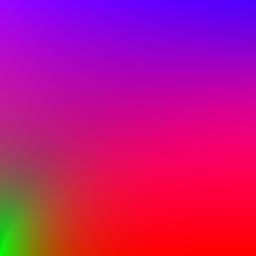

In [3]:
from load_atoms import view

view(train[0], show_bonds=True)

## Configuration

Great - now lets train a model. To do this, we have specified the following in our ``quickstart-cgap17.yaml`` file:

* the model architecture to instantiate and train, here [NequIP](https://jla-gardner.github.io/graph-pes/models/many-body/nequip.html). Note that we also include a [FixedOffset](https://jla-gardner.github.io/graph-pes/models/offsets.html#graph_pes.models.FixedOffset) component to account for the fact that the C-GAP-17 labels have an arbitrary offset.
* the data to train on, here the [C-GAP-17](https://jla-gardner.github.io/load-atoms/datasets/C-GAP-17.html) dataset we just downloaded
* the loss function to use, here a combination of a per-atom energy loss and a per-atom force loss
* and various other training hyperparameters (e.g. the learning rate, batch size, etc.)



We can download [this config file](https://raw.githubusercontent.com/jla-gardner/graph-pes/refs/heads/main/docs/source/quickstart/quickstart-cgap17.yaml) using wget:

In [4]:
%%bash

if [ ! -f quickstart-cgap17.yaml ]; then
    wget https://tinyurl.com/graph-pes-quickstart-cgap17 -O quickstart-cgap17.yaml
fi

## Training

You can see the output of the original training run I ran in this [Weights and Biases dashboard](https://wandb.ai/jla-gardner/graph-pes-quickstart/runs/train-nequip).


In [12]:
!graph-pes-train quickstart-cgap17.yaml general/run_id=train-nequip

[graph-pes INFO]: Started `graph-pes-train` at 2025-04-11 11:21:47.393
[graph-pes INFO]: Successfully parsed config.
[graph-pes INFO]: Logging to graph-pes-results/train-nequip/rank-0.log
[graph-pes INFO]: ID for this training run: train-nequip
[graph-pes INFO]: 
Output for this training run can be found at:
   ‚îî‚îÄ graph-pes-results/train-nequip
      ‚îú‚îÄ rank-0.log         # find a verbose log here
      ‚îú‚îÄ model.pt           # the best model (according to valid/loss/total)
      ‚îú‚îÄ lammps_model.pt    # the best model deployed to LAMMPS
      ‚îú‚îÄ train-config.yaml  # the complete config used for this run
      ‚îî‚îÄ summary.yaml       # the summary of the training run

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jla-gardner to https://api.wandb.ai. Use `wan

# Model analysis

As part of the ``graph-pes-train`` run, the model was tested on the test set we specified in the config file.
In depth analysis, and of course actually using the models, requires a bit more code.

You can see from the command we used and the training logs that this model has been saved as ``graph-pes-results/train-nequip/model.pt``.

Let's load the best model from the above training run, put it on the GPU if available, and get it ready for evaluation:

In [4]:
import torch
from graph_pes.models import load_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = (
    load_model("graph-pes-results/train-nequip/model.pt")  # load the model
    .to(device)  # move to GPU if available
    .eval()  # set to evaluation mode
)

The easiest way to use our model is to use the [GraphPESCalculator](https://jla-gardner.github.io/graph-pes/tools/ase.html#graph_pes.utils.calculator.GraphPESCalculator) to act directly on [ase.Atoms](https://wiki.fysik.dtu.dk/ase/ase/atoms.html#module-ase.atoms) objects:

<!-- [GraphPESModel](https://jla-gardner.github.io/graph-pes/models/root.html#graph_pes.GraphPESModel) act on [AtomicGraph](https://jla-gardner.github.io/graph-pes/atomic_graph.html#graph_pes.AtomicGraph) objects. 

We can easily convert our [ase.Atoms](https://wiki.fysik.dtu.dk/ase/ase/atoms.html#module-ase.atoms) objects into [AtomicGraph](https://jla-gardner.github.io/graph-pes/data/atomic_graph.html#graph_pes.AtomicGraph) objects using [AtomicGraph.from_ase](https://jla-gardner.github.io/graph-pes/data/atomic_graph.html#graph_pes.AtomicGraph) (we could also use the [GraphPESCalculator](https://jla-gardner.github.io/graph-pes/utils.html#graph_pes.utils.calculator.GraphPESCalculator) to act directly on the [ase.Atoms](https://wiki.fysik.dtu.dk/ase/ase/atoms.html#module-ase.atoms) objects if we wanted to). -->

In [5]:
calculator = best_model.ase_calculator()
calculator.calculate(test[0], properties=["energy", "forces", "stress"])
calculator.results

{'energy': -9994.06640625,
 'forces': array([[-4.2254949e+00,  5.9772301e-01,  8.1164581e-01],
        [-9.8559284e-01,  2.4811971e+00, -8.7177944e+00],
        [ 2.1818477e-01, -3.9657693e+00,  5.4294224e+00],
        [-2.2534198e-01, -6.7757750e-01,  3.9687052e-01],
        [-1.6062340e-01,  1.6424814e+00,  1.6815267e+00],
        [ 3.8409348e+00, -2.3497558e+00,  1.0593975e+00],
        [ 2.6760058e+00,  1.4250646e+00,  1.5218904e+00],
        [ 1.8543882e+00, -6.4903003e-01, -1.2432039e+00],
        [ 1.2891605e+00,  1.8805935e+00, -1.1635600e+00],
        [ 6.2873564e+00,  6.9245615e+00,  2.0475407e+00],
        [ 1.1643579e+00,  9.7333103e-01,  2.1005793e+00],
        [-4.5520332e-01, -1.0353167e+00,  9.0359229e-01],
        [ 2.0876718e+00, -2.0918713e+00, -1.7296244e+00],
        [ 7.9885268e-01,  2.8175316e+00,  4.0605450e+00],
        [ 7.1246386e-01, -3.1887600e+00, -2.6775827e+00],
        [-6.5839797e-02, -1.8803604e+00, -2.6095929e+00],
        [-2.1252718e+00,  1.7640973

We can see from a single data point that our model has done a reasonable job of learning the PES:

In [6]:
calculator.get_potential_energy(test[0]), test[0].info["energy"]

(-9994.06640625, np.float64(-9998.70784))

``graph-pes`` provides a few utility functions for visualising model performance:

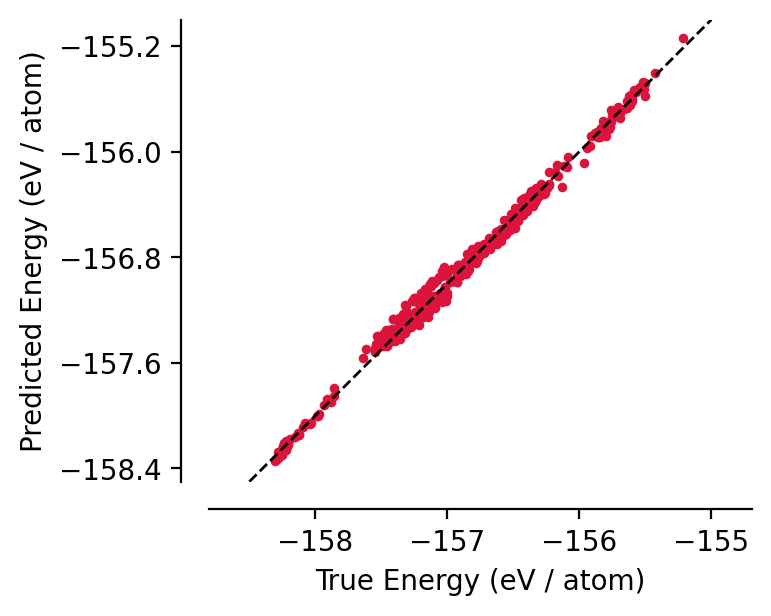

In [7]:
import matplotlib.pyplot as plt
from graph_pes.utils.analysis import parity_plot

%config InlineBackend.figure_format = 'retina'

parity_plot(
    best_model,
    test,
    property="energy_per_atom",
    units="eV / atom",
    lw=0,
    s=12,
    color="crimson",
)
plt.xlim(-158.5, -155)
plt.ylim(-158.5, -155);

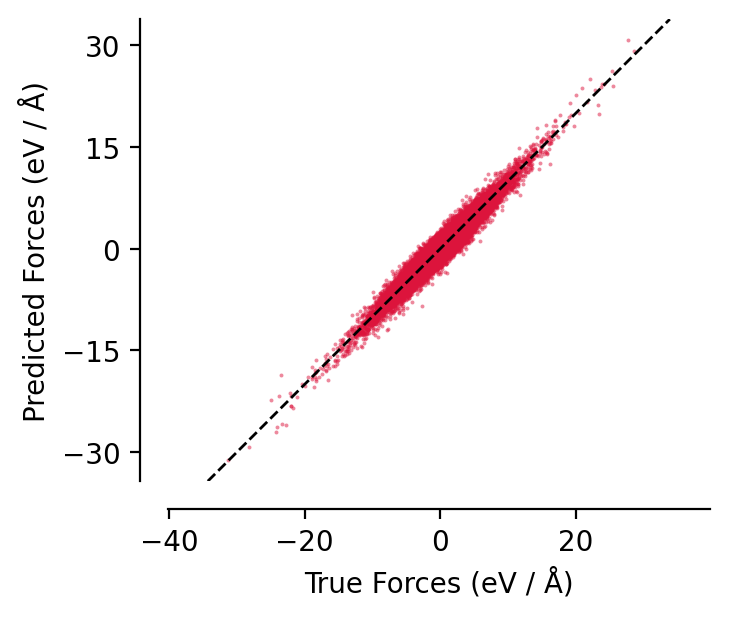

In [8]:
parity_plot(
    best_model,
    test,
    property="forces",
    units="eV / √Ö",
    lw=0,
    s=2,
    alpha=0.5,
    color="crimson",
)

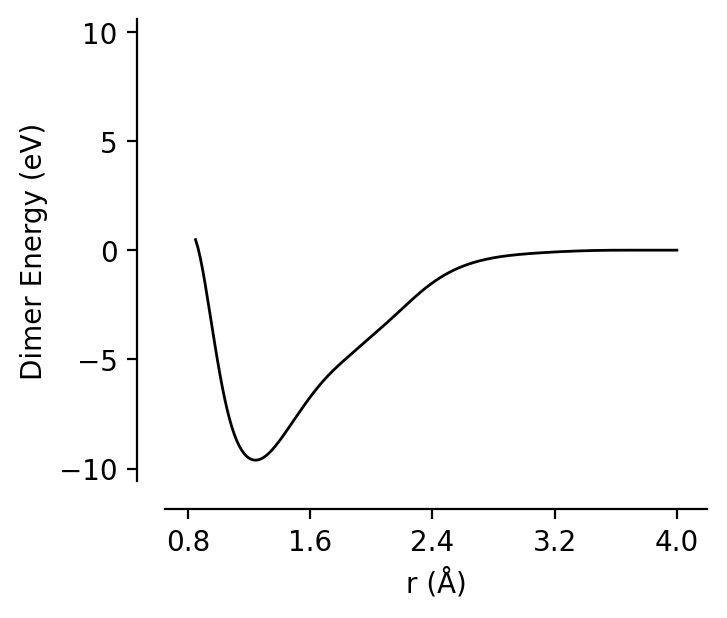

In [9]:
from graph_pes.utils.analysis import dimer_curve

dimer_curve(best_model, system="CC", units="eV", rmin=0.85, rmax=4.0);

Beyond static evaluations, there are many more use cases for these models - head over to e.g. our [ASE examples](https://jla-gardner.github.io/graph-pes/tools/ase.html) notebook for more details

# Fine-tuning

Let's now take the model we trained above, and fine-tune it on the [C-GAP-20U](https://jla-gardner.github.io/load-atoms/datasets/C-GAP-20U.html) dataset.

In [12]:
import ase.io
from load_atoms import load_dataset

structures = load_dataset("C-GAP-20U")
cgap20_train, cgap20_val, cgap20_test = structures.random_split([0.8, 0.1, 0.1])

ase.io.write("train-cgap20u.xyz", cgap20_train)
ase.io.write("val-cgap20u.xyz", cgap20_val)
ase.io.write("test-cgap20u.xyz", cgap20_test)

Output()

We can see that the ``C-GAP-20U`` dataset clearly has labels with a different arbitrary offset to the ``C-GAP-17`` dataset. 

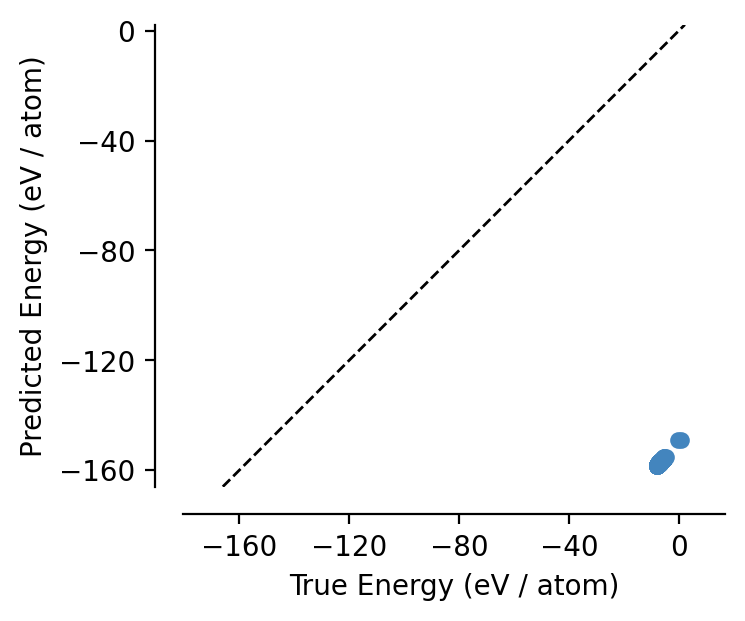

In [14]:
parity_plot(
    best_model,
    cgap20_test,
    property="energy_per_atom",
    units="eV / atom",
)

This is to be expected, since the DFT codes used to label ``C-GAP-17`` and ``C-GAP-20U`` are different.

If we were to fine-tune our existing model as-is on this dataset, bad things would happen very quickly - the large energy errors would lead to large gradients that would quickly destroy the model.

Thankfully, ``graph-pes`` provides the ``auto_fit_reference_energies`` config option to automatically handle this common problem during fine-tuning.

In [18]:
%%bash

if [ ! -f finetune-cgap20u.yaml ]; then
    wget https://tinyurl.com/graph-pes-finetune-cgap20u -O finetune-cgap20u.yaml
fi

In [19]:
!graph-pes-train finetune-cgap20u.yaml \
    model/+load_model/path=graph-pes-results/train-nequip/model.pt \
    general/run_id=finetune

[graph-pes INFO]: Started `graph-pes-train` at 2025-04-11 11:56:59.563
[graph-pes INFO]: Successfully parsed config.
[graph-pes INFO]: Logging to graph-pes-results/finetune/rank-0.log
[graph-pes INFO]: ID for this training run: finetune
[graph-pes INFO]: 
Output for this training run can be found at:
   ‚îî‚îÄ graph-pes-results/finetune
      ‚îú‚îÄ rank-0.log         # find a verbose log here
      ‚îú‚îÄ model.pt           # the best model (according to valid/loss/total)
      ‚îú‚îÄ lammps_model.pt    # the best model deployed to LAMMPS
      ‚îú‚îÄ train-config.yaml  # the complete config used for this run
      ‚îî‚îÄ summary.yaml       # the summary of the training run

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jla-gardner to https://api.wandb.ai. Use `wandb login --r

We can see that the resulting model makes energy predictions on the same scale as the labels in the ``C-GAP-20U`` dataset, and that these predictions are reasonably accurate for a combined 10 minutes of pre-training + fine-tuning time:

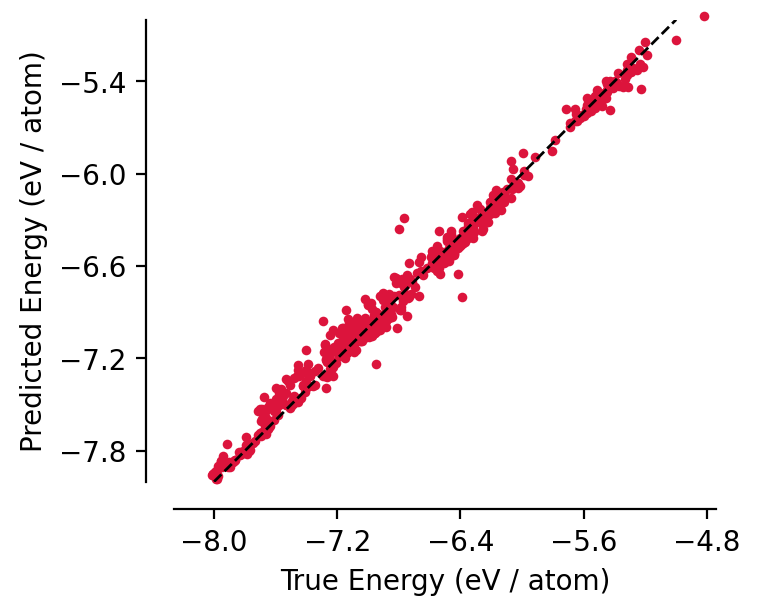

In [20]:
fine_tuned_model = load_model("graph-pes-results/finetune/model.pt")
parity_plot(
    fine_tuned_model,
    cgap20_test,
    property="energy_per_atom",
    units="eV / atom",
    lw=0,
    s=12,
    color="crimson",
)
plt.xlim(-8, -5)
plt.ylim(-8, -5);